<a href="https://colab.research.google.com/github/ThinkingBeyond/BeyondAI-2024/blob/main/Wine_Dataset_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a code that compares Kolmogorov Arnold Networks (KANs) with the Multi-Layer Pereptron (MLPs) using the wine dataset

I aim to use graphical representation to understand how each model converges, the maximum accuracy achieved by each model, the loss each model has while training on the dataset.

The comparison would also be done using some criterias such as precision,recall,f1 score and confusion matrix

##Import Necessary Libraries

In [1]:
!pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-nsnu9o7p
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-nsnu9o7p
  Resolved https://github.com/KindXiaoming/pykan.git to commit f871c26d4df788ec1ba309c2c9c1803d82606b06
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78208 sha256=6f5ac4397161e4263373ba5583d0433e14516b25cb01716d87b01e576f783911
  Stored in directory: /tmp/pip-ephem-wheel-cache-ein3sh0g/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


In [2]:
!python --version
!pip install scikit-learn pandas matplotlib torch numpy

Python 3.10.12


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from kan import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings("ignore")

##Models
The models are being called here along with the number of layers, activation function and other hyperparameters needed for the initial run

In [4]:
#MLP Model
mlp = MLPClassifier()
#KAN Model
kan = KAN(width=[13,5,3]) # should be adjusted based on dataset

checkpoint directory created: ./model
saving model version 0.0


#Functions
All the functions to be used for calculating the accuracies, losses, precision, recall, confusion matrix. The function to plot the graph is also written here.

##Model Functions

In [5]:
def MLP_run(mlp,X_train,y_train,X_test,y_test,epochs):
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
  train_accuracies,test_accuracies = [],[]
  train_losses,test_losses = [],[]
  criterion = nn.MSELoss()
  start_time = time.time()

  for epoch in range(epochs):
    mlp.partial_fit(X_train, y_train_tensor, classes=np.unique(y_train_tensor))
    y_pred_train = mlp.predict(X_train)
    train_acc = accuracy_score(y_train_tensor, torch.tensor(y_pred_train))
    train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float32), y_train_tensor)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],MLP Train Loss: {train_loss.item():.3f}, MLP Train Accuracy: {train_acc}')

  for epoch in range(epochs):
    y_pred_test = mlp.predict(X_test)
    test_acc = accuracy_score(y_test_tensor, torch.tensor(y_pred_test))
    test_loss = criterion(torch.tensor(y_pred_test, dtype=torch.float32), y_test_tensor)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],MLP Test Loss: {test_loss.item():.3f}, MLP Test Accuracy: {test_acc}')
  end_time = time.time()
  MLP_Execution_Time = end_time - start_time
  return train_accuracies,test_accuracies,train_losses,test_losses,MLP_Execution_Time


def KAN_run(model,X_train,y_train,X_test,y_test,epochs):
  y_train_long = torch.tensor(y_train, dtype=torch.long)
  y_test_long = torch.tensor(y_test, dtype=torch.long)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  loss_fn = nn.CrossEntropyLoss()
  kan_train_accuracy = []
  kan_test_accuracy = []
  kan_train_loss = []
  kan_test_loss = []
  starting_time = time.time()
  dataset ={'train_input':torch.tensor(X_train),'train_target':y_train_long}

  for epoch in range(epochs): #training
    optimizer.zero_grad()
    outputs = model(dataset['train_input'])
    predicted = torch.argmax(outputs, dim=1)
    train_accuracy = accuracy_score(dataset['train_target'], predicted)
    train_loss = loss_fn(outputs, dataset['train_target'])
    train_loss.backward()
    optimizer.step()
    kan_train_accuracy.append(train_accuracy)
    kan_train_loss.append(train_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Train Loss: {train_loss.item():.3f}, KAN Train Accuracy: {train_accuracy}')

  for epoch in range(epochs): # testing
    predicted = model(x_test_tensor)
    test_accuracy = accuracy_score(y_test_long, predicted.argmax(1))
    test_loss = loss_fn(predicted, y_test_long)
    kan_test_accuracy.append(test_accuracy)
    kan_test_loss.append(test_loss.item())
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}],KAN Test Loss: {test_loss.item():.3f},KAN Test Accuracy: {test_accuracy:.3f}')
  final_time = time.time()
  KAN_Execution_Time = final_time - starting_time
  return kan_train_accuracy, kan_test_accuracy, kan_train_loss, kan_test_loss, KAN_Execution_Time

##Model Run Function

In [6]:
def run_models(epochs):
  mlp_model_run = MLP_run(mlp,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor,epochs)
  mlp_metrics = [mlp_model_run[0],mlp_model_run[1],mlp_model_run[2],mlp_model_run[3]]
  print(f'MLP Execution time: {mlp_model_run[4]:.2f} seconds')

  kan_model_run = KAN_run(kan,x_train_tensor,y_train_tensor,x_test_tensor,y_test_tensor,epochs)
  kan_metrics = [kan_model_run[0],kan_model_run[1],kan_model_run[2],kan_model_run[3]]
  print(f'KAN Execution time: {kan_model_run[4]:.2f} seconds')
  return mlp_metrics,kan_metrics

##Plot Function

In [7]:
def plot_comparison_over_epochs(mlp_metrics,kan_metrics, num_epochs):
    epochs = range(1, num_epochs + 1)
    mlp_train_acc, mlp_test_acc, mlp_train_loss, mlp_test_loss = mlp_metrics
    kan_train_acc, kan_test_acc, kan_train_loss, kan_test_loss = kan_metrics
    plt.figure(figsize=(10,5))

    # Graph of Train Accuracy for both models over number of epochs
    plt.subplot(121)
    plt.plot(epochs, mlp_train_acc, label='MLP Train Accuracy',color='blue',marker='o')
    plt.plot(epochs, kan_train_acc, label='KAN Train Accuracy',color='red',marker='x')
    plt.plot(epochs, mlp_test_acc, label='MLP Test Accuracy',color='green',marker='o')
    plt.plot(epochs, kan_test_acc, label='KAN Test Accuracy',color='yellow',marker='x')
    plt.ylim(0.5, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('MLP and KAN Train Accuracy Over Epochs')
    plt.legend()

    # Graph of loss of both models during training
    plt.subplot(122)
    plt.plot(epochs, mlp_train_loss, label='MLP Train Loss',color='blue',marker='o')
    plt.plot(epochs, kan_train_loss, label='KAN Train Loss',color='red',marker='x')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

##Comparison Criteria Functions

In [8]:
def criteria_comparison(mlp,kan,x_test_tensor,y_test_tensor):
  y_pred_mlp = mlp.predict(x_test_tensor)
  y_pred_kan = kan(x_test_tensor).argmax(1)
  mlp_classification= classification_report(y_test_tensor, y_pred_mlp)
  kan_classification = classification_report(y_test_long, y_pred_kan)
  mlp_confusion = confusion_matrix(y_test_tensor, y_pred_mlp)
  kan_confusion = confusion_matrix(y_test_long, y_pred_kan)
  print(f'MLP Classification Report:\n{mlp_classification}')
  print(f'MLP Confusion Matrix:\n{mlp_confusion}')
  print(f'KAN Classification Report:\n{kan_classification}')
  print(f'KAN Confusion Matrix:\n{kan_confusion}')

#Dataset
The dataset to be used for the analysis is loaded here as well as preparation for the dataset using standard scaler(to make every feature have a mean of 0 and a standard deviation of 1) for faster convergence and imporved performance

##Load Dataset

In [9]:
url_wine = 'https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv'
df = pd.read_csv(url_wine)
df['Wine'] = df['Wine'] - 1
x = df.drop('Wine', axis=1).values
y = df['Wine'].values

##Prepare Dataset

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
# Converting data to tensors
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_train_long = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_test_long = torch.tensor(y_test, dtype=torch.long)

# Model Run
Running the models over 100 epochs with different hidden layers for MLP and KAN with that of KAN being lower than MLP at all points

Plotting the accuracies and loss over epochs

Calculating other comparison criteria like the classification report and confusion matrix

In [11]:
epochs = 100

## Model Run with hidden layers
MLP: 2(64,32) and KAN: 1(27)




In [12]:
# mlp hyperparameter tunning for mlp0
param_grid_mlp0 = {
    'hidden_layer_sizes': [(64,32)],
    'activation': ['relu', 'tanh'],
    'alpha':[0.001,0.01],
    'solver':['adam','sgd'],
    'learning_rate_init':[0.01,0.001,0.1],
    'learning_rate':['adaptive','constant']}
mlp_tune0 = MLPClassifier(max_iter=500, random_state=42)
clfmlp0 = GridSearchCV(mlp_tune0, param_grid_mlp0, cv=5, scoring='accuracy')
clfmlp0.fit(X_train, y_train)
print(f"Best accuracy: {clfmlp0.best_score_}")
print(f"Best parameters: {clfmlp0.best_params_}")

Best accuracy: 0.9623376623376624
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (64, 32), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'adam'}


In [13]:
# kan hyperparameter tunning for kan0
grids0 = range(3,11,1)
ks0 = range(2,9,1)
noises0 = np.arange(0.1,0.9,0.1).tolist()
mult_arities0 = [2,3,4,5]
accuracies0=[]
hyperparameters0 = []
for grid in grids0:
  for k in ks0:
    for noise in noises0:
      for mult_arity in mult_arities0:
        kan = KAN(width=[13,27,3], grid=grid, k=k,noise_scale=noise,mult_arity=mult_arity,seed=42)
        y_pred = kan(x_train_tensor).argmax(1)
        accuracy = accuracy_score(y_train_tensor, y_pred)
        accuracies0.append(accuracy)
        hyperparameters0.append((grid,k,noise,mult_arity))
print(max(accuracies0))
index = accuracies0.index(max(accuracies0))
print(hyperparameters0[index])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model vers

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 0.802, MLP Train Accuracy: 0.6226415094339622
Epoch [20/100],MLP Train Loss: 0.198, MLP Train Accuracy: 0.8867924528301887
Epoch [30/100],MLP Train Loss: 0.028, MLP Train Accuracy: 0.9716981132075472
Epoch [40/100],MLP Train Loss: 0.019, MLP Train Accuracy: 0.9811320754716981
Epoch [50/100],MLP Train Loss: 0.009, MLP Train Accuracy: 0.9905660377358491
Epoch [60/100],MLP Train Loss: 0.009, MLP Train Accuracy: 0.9905660377358491
Epoch [70/100],MLP Train Loss: 0.000, MLP Train Accuracy: 1.0
Epoch [80/100],MLP Train Loss: 0.000, MLP Train Accuracy: 1.0
Epoch [90/100],MLP Train Loss: 0.000, MLP Train Accuracy: 1.0
Epoch [100/100],MLP Train Loss: 0.000, MLP Train Accuracy: 1.0
Epoch [10/100],MLP Test Loss: 0.028, MLP Test Accuracy: 0.9722222222222222
Epoch [20/100],MLP Test Loss: 0.028, MLP Test Accuracy: 0.9722222222222222
Epoch [30/100],MLP Test Loss: 0.028, MLP Test Accuracy: 0.9722222222222222
E

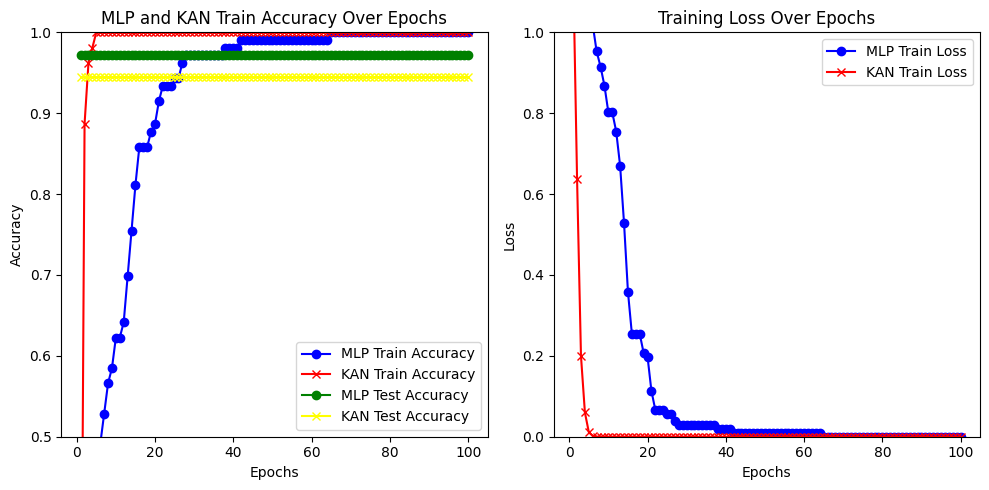

MLP Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        26
         1.0       1.00      0.96      0.98        27
         2.0       0.95      1.00      0.97        19

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72

MLP Confusion Matrix:
[[26  0  0]
 [ 0 26  1]
 [ 0  0 19]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.50      0.59        26
           1       0.61      0.63      0.62        27
           2       0.42      0.58      0.49        19

    accuracy                           0.57        72
   macro avg       0.58      0.57      0.57        72
weighted avg       0.60      0.57      0.57        72

KAN Confusion Matrix:
[[13  6  7]
 [ 2 17  8]
 [ 3  5 11]]


In [14]:
# MLP Model
mlp_0 = MLPClassifier(hidden_layer_sizes=(64,32),
                    max_iter= 500,
                    activation='tanh',
                    learning_rate_init= 0.01,
                    learning_rate='adaptive',
                    alpha= 0.1,
                    solver='adam',
                    random_state=42,
                    verbose = False)

# KAN Model
kan_0 = KAN(width=[13,27,3], grid=3, k=2, noise_scale=0.8,mult_arity=2, seed=42)
kan_0.update_grid_from_samples(x_train_tensor)
mlp_metrics_0,kan_metrics_0 = run_models(epochs)
plot_comparison_over_epochs(mlp_metrics_0, kan_metrics_0,epochs)
mlp_0.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_0,kan_0,x_test_tensor,y_test_tensor)

## Model Run with hidden layers
MLP: 3(40,25,10) and KAN: 2(27,10)

In [15]:
# mlp hyperparameter tunning for mlp1
param_grid_mlp1 = {
    'hidden_layer_sizes': [(40,25,10)],
    'activation': ['relu', 'tanh'],
    'alpha':[0.001,0.01,0.1,1],
    'solver':['adam','sgd'],
    'learning_rate_init':[0.01,0.001,0.1],
    'learning_rate':['adaptive','constant']}
mlp_tune1 = MLPClassifier(max_iter=500, random_state=42)
clfmlp1 = GridSearchCV(mlp_tune1, param_grid_mlp1, cv=5, scoring='accuracy')
clfmlp1.fit(X_train, y_train)
print(f"Best accuracy: {clfmlp1.best_score_}")
print(f"Best parameters: {clfmlp1.best_params_}")

Best accuracy: 0.980952380952381
Best parameters: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (40, 25, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam'}


In [16]:
# kan hyperparameter tunning for kan1
grids1 = range(3,11,1)
ks1 = range(2,9,1)
noises1 = np.arange(0.1,0.9,0.1).tolist()
mult_arities1 = [2,3,4,5]
accuracies1=[]
hyperparameters1 = []
for grid in grids1:
  for k in ks1:
    for noise in noises1:
      for mult_arity in mult_arities1:
        kan = KAN(width=[13,27,10,3], grid=grid, k=k,noise_scale=noise,mult_arity=mult_arity,seed=42)
        y_pred = kan(x_train_tensor).argmax(1)
        accuracy = accuracy_score(y_train_long, y_pred)
        accuracies1.append(accuracy)
        hyperparameters1.append((grid,k,noise,mult_arity))
print(max(accuracies1))
index = accuracies1.index(max(accuracies1))
print(hyperparameters1[index])


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model vers

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 1.613, MLP Train Accuracy: 0.32075471698113206
Epoch [20/100],MLP Train Loss: 1.434, MLP Train Accuracy: 0.3867924528301887
Epoch [30/100],MLP Train Loss: 1.038, MLP Train Accuracy: 0.5283018867924528
Epoch [40/100],MLP Train Loss: 0.745, MLP Train Accuracy: 0.6509433962264151
Epoch [50/100],MLP Train Loss: 0.623, MLP Train Accuracy: 0.7169811320754716
Epoch [60/100],MLP Train Loss: 0.434, MLP Train Accuracy: 0.7924528301886793
Epoch [70/100],MLP Train Loss: 0.321, MLP Train Accuracy: 0.8490566037735849
Epoch [80/100],MLP Train Loss: 0.226, MLP Train Accuracy: 0.8867924528301887
Epoch [90/100],MLP Train Loss: 0.226, MLP Train Accuracy: 0.8867924528301887
Epoch [100/100],MLP Train Loss: 0.170, MLP Train Accuracy: 0.9150943396226415
Epoch [10/100],MLP Test Loss: 0.347, MLP Test Accuracy: 0.8611111111111112
Epoch [20/100],MLP Test Loss: 0.347, MLP Test Accuracy: 0.8611111111111112
Epoch [30/100],

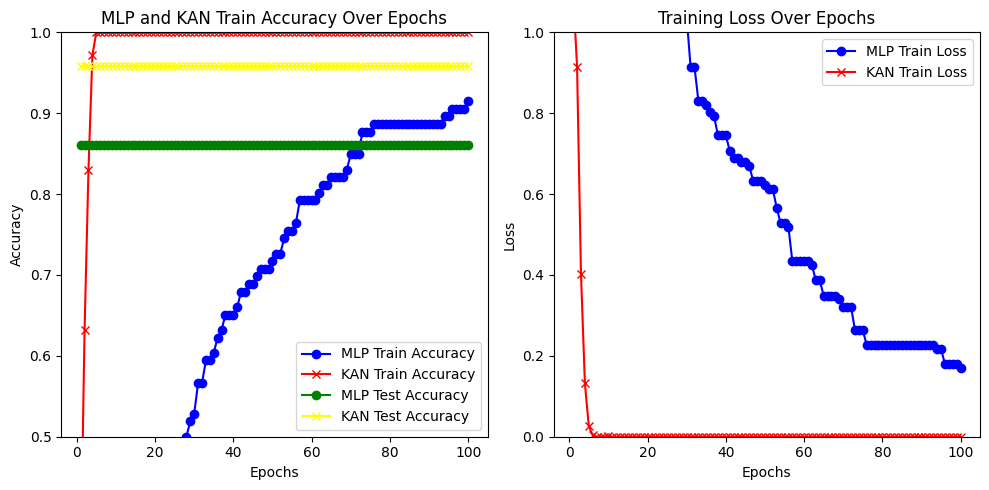

MLP Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        26
         1.0       1.00      0.96      0.98        27
         2.0       0.95      1.00      0.97        19

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72

MLP Confusion Matrix:
[[26  0  0]
 [ 0 26  1]
 [ 0  0 19]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        26
           1       0.58      0.70      0.63        27
           2       0.82      0.47      0.60        19

    accuracy                           0.67        72
   macro avg       0.70      0.65      0.66        72
weighted avg       0.69      0.67      0.66        72

KAN Confusion Matrix:
[[20  4  2]
 [ 8 19  0]
 [ 0 10  9]]


In [17]:
mlp.coefs_ = [np.random.randn(*coef.shape) for coef in mlp.coefs_]  # Reset weights
mlp.intercepts_ = [np.random.randn(*intercept.shape) for intercept in mlp.intercepts_]  # Reset biases
mlp_1 = MLPClassifier(hidden_layer_sizes=(40,25,10),
                    max_iter=500,
                    activation='relu',
                    learning_rate_init= 0.1,
                    learning_rate='adaptive',
                    alpha= 1,
                    solver='adam',
                    random_state=42,
                    verbose = False)


kan_1= KAN(width=[13,27,10,3], grid=4, k=6, noise_scale=0.2, mult_arity=2, seed=42)
kan_1.update_grid_from_samples(x_train_tensor)
num_epochs = 100
mlp_metrics_1,kan_metrics_1 = run_models(num_epochs)
plot_comparison_over_epochs(mlp_metrics_1, kan_metrics_1,num_epochs)
mlp_1.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_1,kan_1,x_test_tensor,y_test_tensor)

## Model Run with hidden layer
MLP:4 layers and KAN: 3(27,19,10)

In [ ]:
# mlp hyperparameter tunning for mlp2
param_grid_mlp2 = {
    'hidden_layer_sizes': [(64,32,16,8),(32,32,16,8),(16,8,4,3)],
    'activation': ['relu', 'tanh'],
    'alpha':[0.001,0.01,0.1,1],
    'solver':['adam','sgd'],
    'learning_rate_init':[0.01,0.001,0.1],
    'learning_rate':['adaptive','constant']}
mlp.coefs_ = [np.random.randn(*coef.shape) for coef in mlp.coefs_]
mlp.intercepts_ = [np.random.randn(*intercept.shape) for intercept in mlp.intercepts_]
mlp_tune2 = MLPClassifier(max_iter=500, random_state=42)
clfmlp = GridSearchCV(mlp_tune2, param_grid_mlp2, cv=5, scoring='accuracy')
clfmlp.fit(X_train, y_train)
print(f"Best accuracy: {clfmlp.best_score_}")
print(f"Best parameters: {clfmlp.best_params_}")

In [19]:
# kan hyperparameter tunning for kan2
grids2 = range(3,11,1)
ks2 = range(2,9,1)
noises2 = np.arange(0.1,0.9,0.1).tolist()
mult_arities2 = [2,3,4,5]
accuracies2=[]
hyperparameters2 = []
for grid in grids2:
  for k in ks2:
    for noise in noises2:
      for mult_arity in mult_arities2:
        kan = KAN(width=[13,27,19,10,3], grid=grid, k=k,noise_scale=noise,mult_arity=mult_arity,seed=42)
        y_pred = kan(x_train_tensor).argmax(1)
        accuracy = accuracy_score(y_train_tensor, y_pred)
        accuracies2.append(accuracy)
        hyperparameters2.append((grid,k,noise,mult_arity))
print(max(accuracies2))
index = accuracies2.index(max(accuracies2))
print(hyperparameters2[index])


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model vers

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/100],MLP Train Loss: 1.651, MLP Train Accuracy: 0.3113207547169811
Epoch [20/100],MLP Train Loss: 1.509, MLP Train Accuracy: 0.33962264150943394
Epoch [30/100],MLP Train Loss: 1.302, MLP Train Accuracy: 0.4339622641509434
Epoch [40/100],MLP Train Loss: 0.906, MLP Train Accuracy: 0.5754716981132075
Epoch [50/100],MLP Train Loss: 0.708, MLP Train Accuracy: 0.660377358490566
Epoch [60/100],MLP Train Loss: 0.632, MLP Train Accuracy: 0.7075471698113207
Epoch [70/100],MLP Train Loss: 0.519, MLP Train Accuracy: 0.7641509433962265
Epoch [80/100],MLP Train Loss: 0.349, MLP Train Accuracy: 0.8207547169811321
Epoch [90/100],MLP Train Loss: 0.311, MLP Train Accuracy: 0.8584905660377359
Epoch [100/100],MLP Train Loss: 0.226, MLP Train Accuracy: 0.8867924528301887
Epoch [10/100],MLP Test Loss: 0.486, MLP Test Accuracy: 0.8055555555555556
Epoch [20/100],MLP Test Loss: 0.486, MLP Test Accuracy: 0.8055555555555556
Epoch [30/100],M

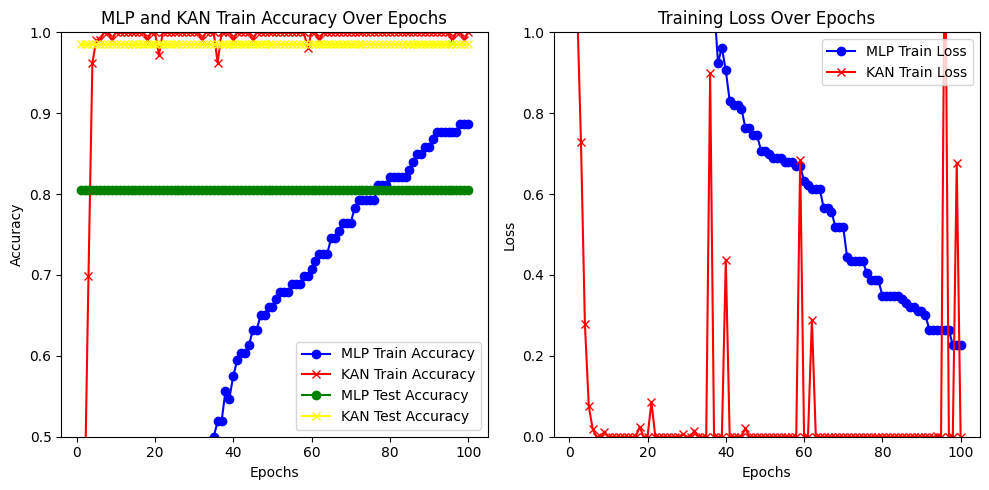

MLP Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        26
         1.0       1.00      0.93      0.96        27
         2.0       0.95      1.00      0.97        19

    accuracy                           0.97        72
   macro avg       0.97      0.98      0.97        72
weighted avg       0.97      0.97      0.97        72

MLP Confusion Matrix:
[[26  0  0]
 [ 1 25  1]
 [ 0  0 19]]
KAN Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        26
           1       0.56      0.37      0.44        27
           2       0.53      0.42      0.47        19

    accuracy                           0.61        72
   macro avg       0.59      0.60      0.57        72
weighted avg       0.59      0.61      0.58        72

KAN Confusion Matrix:
[[26  0  0]
 [10 10  7]
 [ 3  8  8]]


In [20]:
mlp.coefs_ = [np.random.randn(*coef.shape) for coef in mlp.coefs_]  # Reset weights
mlp.intercepts_ = [np.random.randn(*intercept.shape) for intercept in mlp.intercepts_]  # Reset biases
mlp_2 = MLPClassifier(hidden_layer_sizes=(64,32,16,8),
                    max_iter=500,
                    activation='relu',
                    learning_rate_init= 0.1,
                    learning_rate='adaptive',
                    alpha= 0.01,
                    solver='adam',
                    random_state=42,
                    verbose = False)


kan_2= KAN(width=[13,27,19,10,3], grid=4, k=2, mult_arity=2, noise_scale=0.2, seed=42)
kan_2.update_grid_from_samples(x_train_tensor)
num_epochs = 100
mlp_metrics_2,kan_metrics_2 = run_models(num_epochs)
plot_comparison_over_epochs(mlp_metrics_2, kan_metrics_2,num_epochs)
mlp_2.fit(x_train_tensor, y_train_tensor)
criteria_comparison(mlp_2,kan_2,x_test_tensor,y_test_tensor)